# Load modules

In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV

import shap 
%matplotlib notebook
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load data

In [17]:
data = np.load(os.path.join('data', 'dataset_smile_challenge.npy'), allow_pickle = True).item()

#training dataset 
train = data['train']
deep_features_train = train['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_train = train['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

#test dataset
test = data['test']
deep_features_test = test['deep_features'] # for deep features {'ECG_features_C', 'ECG_features_T'}.
handcrafted_features_test = test['hand_crafted_features'] # for hand-crafted features {'ECG_features', 'GSR_features'}.

# extracting labels and converting labels >= 1 to just 1.
y_train = train['labels']
th = 1
y_train[y_train<th] = 0
y_train[y_train>0] = 1

idx = np.random.permutation(len(deep_features_train['ECG_features_C']))
deep_features_train['ECG_features_C'] = deep_features_train['ECG_features_C'][idx]
deep_features_train['ECG_features_T'] = deep_features_train['ECG_features_T'][idx]
deep_features_train['masking'] = deep_features_train['masking'][idx]
handcrafted_features_train['ECG_features'] = handcrafted_features_train['ECG_features'][idx]
handcrafted_features_train['ECG_masking'] = handcrafted_features_train['ECG_masking'][idx]
handcrafted_features_train['GSR_features'] = handcrafted_features_train['GSR_features'][idx]
handcrafted_features_train['GSR_masking'] = handcrafted_features_train['GSR_masking'][idx]
y_train = y_train[idx]

# Analyze dataset

In [18]:
#Evaluate shapes
print('Shape of deep_features[ECG_features_C]: ' + str(deep_features_train['ECG_features_C'].shape))
print('Shape of deep_features[ECG_features_T]: ' + str(deep_features_train['ECG_features_T'].shape))

print('Shape of handcrafted_features[ECG_features]: ' + str(handcrafted_features_train['ECG_features'].shape))
print('Shape of handcrafted_features[GSR_features]: ' + str(handcrafted_features_train['GSR_features'].shape))

Shape of deep_features[ECG_features_C]: (2070, 60, 256)
Shape of deep_features[ECG_features_T]: (2070, 60, 64)
Shape of handcrafted_features[ECG_features]: (2070, 60, 8)
Shape of handcrafted_features[GSR_features]: (2070, 60, 12)


# Preprocessing: masking

In [19]:
#Putting to 0 nans in handcrafted_features['ECG_features']
flag_df_egc = np.argwhere(np.isnan(handcrafted_features_train['ECG_features']))
for f in flag_df_egc:
    handcrafted_features_train['ECG_features'][f[0],f[1],f[2]] = 0
flag_df_egc = np.argwhere(np.isnan(handcrafted_features_test['ECG_features']))
for f in flag_df_egc:
    handcrafted_features_test['ECG_features'][f[0],f[1],f[2]] = 0

#Shape understanding 101:
#   We have X features for each timestep.
#   We have 60 timesteps.
#   We have 2070 samples.
#So, each time we are feeding the LSTM with X features, 1 for each timestep, 60 times 

In [20]:
flag_df_egc

array([[156,  34,   0],
       [156,  34,   7],
       [156,  35,   0],
       ...,
       [837,   5,   7],
       [837,  19,   5],
       [837,  20,   5]])

In [21]:
handcrafted_features_train['ECG_features'][436,30,:]

array([0.07989891, 0.17152273, 0.11565636, 0.02476482, 0.67273444,
       0.03118199, 0.00895986, 0.04306553])

In [22]:
np.argwhere(np.isnan(handcrafted_features_train['GSR_features']))

array([], shape=(0, 3), dtype=int64)

<IPython.core.display.Javascript object>


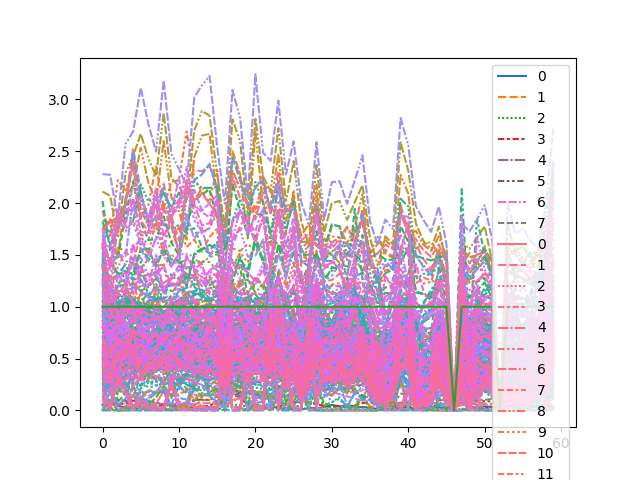

<AxesSubplot:>

In [23]:
#Visualize a data sample
sns.lineplot(data=handcrafted_features_train['ECG_features'][0])

In [24]:
#Visualize a data sample
sns.lineplot(data=deep_features_train['ECG_features_C'][4])
#sns.lineplot(data=deep_features_train['masking'][0])


<AxesSubplot:>

In [25]:
sns.lineplot(data=deep_features_train['masking'][4])

<AxesSubplot:>

<IPython.core.display.Javascript object>


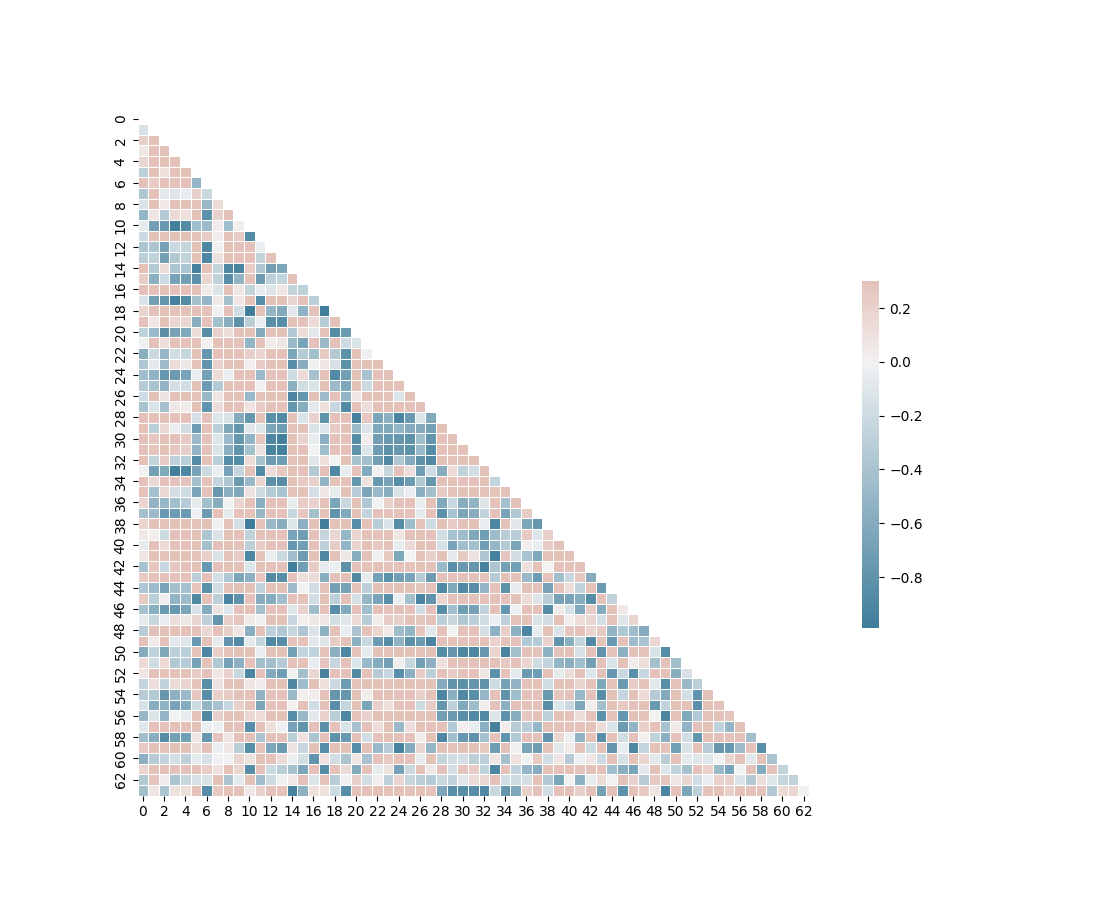

<AxesSubplot:>

In [30]:
d = pd.DataFrame(data=deep_features_train['ECG_features_T'][4])
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [38]:
handcrafted_features_train['GSR_features'][2]

array([[8.27787255e-05, 6.84842616e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.46773155e-10, 0.00000000e+00, 0.00000000e+00,
        2.26845104e-01, 2.29074890e-01, 1.31240643e-01, 2.34812746e-04],
       [8.26019378e-05, 6.81687371e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.50068734e-10, 0.00000000e+00, 0.00000000e+00,
        2.27816793e-01, 2.29074890e-01, 1.30596309e-01, 1.81922195e-04],
       [8.16618242e-05, 6.67018121e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.40164880e-10, 0.00000000e+00, 0.00000000e+00,
        2.28950429e-01, 2.29074890e-01, 1.31007724e-01, 2.14288263e-04],
       [7.44422389e-05, 5.73069995e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.98210126e-09, 0.00000000e+00, 0.00000000e+00,
        2.29848505e-01, 2.29074890e-01, 1.31578961e-01, 2.57496870e-04],
       [6.41537901e-05, 4.63696177e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.09378568e-09, 0.00000000e+00, 0.00

<IPython.core.display.Javascript object>


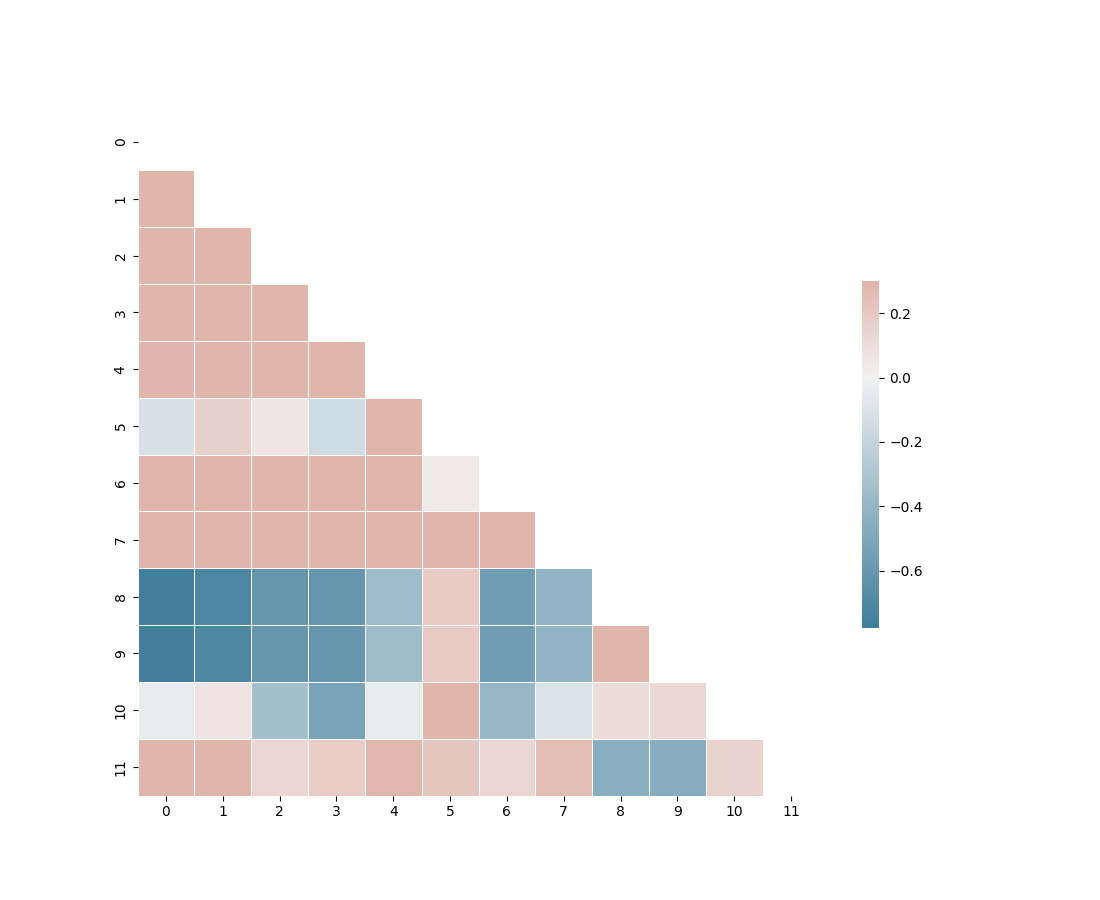

<AxesSubplot:>

In [41]:
d = pd.DataFrame(data=handcrafted_features_train['GSR_features'][10])
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
print('Prevalence of CLASS = 0: ' + str(100*np.sum(y_train)/y_train.shape[0]) + '%')
print('Prevalence of CLASS = 1: ' + str(100*(y_train.shape[0]-np.sum(y_train))/y_train.shape[0]) + '%')

Prevalence of CLASS = 0: 52.7536231884058%
Prevalence of CLASS = 1: 47.2463768115942%


# Model building

In [98]:
inp1 = tf.keras.layers.Input(shape=(deep_features_train['ECG_features_C'].shape[1], deep_features_train['ECG_features_C'].shape[2]))
inp2 = tf.keras.layers.Input(shape=(deep_features_train['ECG_features_T'].shape[1], deep_features_train['ECG_features_T'].shape[2]))
inp3 = tf.keras.layers.Input(shape=(handcrafted_features_train['ECG_features'].shape[1], handcrafted_features_train['ECG_features'].shape[2]))
inp4 = tf.keras.layers.Input(shape=(handcrafted_features_train['GSR_features'].shape[1], handcrafted_features_train['GSR_features'].shape[2]))

n_units = 32
n_batch = 64 
recurrent_dropout = 0.5
dropout = 0.2
optimizer = 'rmsprop'

two_layers = True
three_layers = True

#x = tf.keras.layers.Masking(mask_value=0.)(inp1)
#x = tf.keras.layers.GRU(n_units,recurrent_dropout=recurrent_dropout)(x)
#x = tf.keras.layers.Dropout(dropout)(x)
#x = tf.keras.layers.Dense(1)(x)


x = tf.keras.layers.Masking(mask_value=0.)(inp1)
x = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers or three_layers)(x)
if two_layers or three_layers:
    x = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=three_layers)(x)
if three_layers:
    x = tf.keras.layers.GRU(int(n_units/4), dropout = dropout, recurrent_dropout=recurrent_dropout)(x)

y = tf.keras.layers.Masking(mask_value=0.)(inp2)
y = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers or three_layers)(y)
if two_layers or three_layers:
    y = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=three_layers)(y)
if three_layers:
    y = tf.keras.layers.GRU(int(n_units/4), dropout = dropout, recurrent_dropout=recurrent_dropout)(y)

z = tf.keras.layers.Masking(mask_value=0.)(inp3)
z = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers or three_layers)(z)
if two_layers or three_layers:
    z = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=three_layers)(z)
if three_layers:
    z = tf.keras.layers.GRU(int(n_units/4), dropout = dropout, recurrent_dropout=recurrent_dropout)(z)

w = tf.keras.layers.Masking(mask_value=0.)(inp4)
w = tf.keras.layers.GRU(n_units, dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=two_layers or three_layers)(inp4)
if two_layers or three_layers:
    w = tf.keras.layers.GRU(int(n_units/2), dropout = dropout, recurrent_dropout=recurrent_dropout,return_sequences=three_layers)(w)
if three_layers:
    w = tf.keras.layers.GRU(int(n_units/4), dropout = dropout, recurrent_dropout=recurrent_dropout)(w)
#w = tf.keras.layers.Dense(1)(w)

c = tf.keras.layers.Concatenate()([
    #x,
    y,
    z, 
    w
])

c =  tf.keras.layers.Dense(16, activation='sigmoid')(c)

out =  tf.keras.layers.Dense(1, activation='sigmoid')(c)

model = tf.keras.models.Model(inputs=[
        #inp1,
        inp2,
        inp3,
        inp4
        ],
        outputs=out)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

model.fit(x=[
            #deep_features_train['ECG_features_C'],
            deep_features_train['ECG_features_T'],
            handcrafted_features_train['ECG_features'],
            handcrafted_features_train['GSR_features']
            ], 
          y=y_train, 
          epochs=100,
          validation_split=0.2,
          callbacks=[tensorboard_callback],
          batch_size = n_batch)


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 60, 64)]     0           []                               
                                                                                                  
 input_83 (InputLayer)          [(None, 60, 8)]      0           []                               
                                                                                                  
 masking_56 (Masking)           (None, 60, 64)       0           ['input_82[0][0]']               
                                                                                                  
 masking_57 (Masking)           (None, 60, 8)        0           ['input_83[0][0]']               
                                                                                           

26/26 [==============================] - 4s 173ms/step - loss: 0.6128 - accuracy: 0.6558 - val_loss: 0.6078 - val_accuracy: 0.6570
Epoch 30/100
26/26 [==============================] - 5s 182ms/step - loss: 0.6176 - accuracy: 0.6443 - val_loss: 0.6098 - val_accuracy: 0.6425
Epoch 31/100
26/26 [==============================] - 4s 160ms/step - loss: 0.6139 - accuracy: 0.6516 - val_loss: 0.6046 - val_accuracy: 0.6691
Epoch 32/100
26/26 [==============================] - 4s 152ms/step - loss: 0.6122 - accuracy: 0.6504 - val_loss: 0.6016 - val_accuracy: 0.6739
Epoch 33/100
26/26 [==============================] - 4s 152ms/step - loss: 0.6028 - accuracy: 0.6630 - val_loss: 0.6225 - val_accuracy: 0.6401
Epoch 34/100
26/26 [==============================] - 4s 154ms/step - loss: 0.6130 - accuracy: 0.6473 - val_loss: 0.6054 - val_accuracy: 0.6643
Epoch 35/100
26/26 [==============================] - 4s 161ms/step - loss: 0.6119 - accuracy: 0.6618 - val_loss: 0.6223 - val_accuracy: 0.6546
Epoch

Epoch 86/100
26/26 [==============================] - 5s 172ms/step - loss: 0.5721 - accuracy: 0.6890 - val_loss: 0.5741 - val_accuracy: 0.6836
Epoch 87/100
26/26 [==============================] - 4s 166ms/step - loss: 0.5738 - accuracy: 0.6914 - val_loss: 0.5695 - val_accuracy: 0.7150
Epoch 88/100
26/26 [==============================] - 4s 164ms/step - loss: 0.5691 - accuracy: 0.6890 - val_loss: 0.5670 - val_accuracy: 0.7029
Epoch 89/100
26/26 [==============================] - 4s 165ms/step - loss: 0.5614 - accuracy: 0.7065 - val_loss: 0.5671 - val_accuracy: 0.7029
Epoch 90/100
26/26 [==============================] - 4s 167ms/step - loss: 0.5730 - accuracy: 0.6969 - val_loss: 0.5802 - val_accuracy: 0.7174
Epoch 91/100
26/26 [==============================] - 5s 174ms/step - loss: 0.5717 - accuracy: 0.6884 - val_loss: 0.5652 - val_accuracy: 0.7005
Epoch 92/100
26/26 [==============================] - 5s 184ms/step - loss: 0.5662 - accuracy: 0.7011 - val_loss: 0.5836 - val_accuracy:

In [99]:
%tensorboard --logdir logs/fit

In [100]:
model = tf.keras.models.Model(inputs=[
        #inp1,
        inp2,
        inp3,
        inp4
        ],
        outputs=out)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(model.summary())

model.fit(x=[
            #deep_features_train['ECG_features_C'],
            deep_features_train['ECG_features_T'],
            handcrafted_features_train['ECG_features'],
            handcrafted_features_train['GSR_features']
            ], 
          y=y_train, 
          epochs=50,
          callbacks=[tensorboard_callback],
          batch_size = n_batch)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 60, 64)]     0           []                               
                                                                                                  
 input_83 (InputLayer)          [(None, 60, 8)]      0           []                               
                                                                                                  
 masking_56 (Masking)           (None, 60, 64)       0           ['input_82[0][0]']               
                                                                                                  
 masking_57 (Masking)           (None, 60, 8)        0           ['input_83[0][0]']               
                                                                                           

# Make and save predictions

In [108]:
y_hat_test = model.predict([
            #deep_features_test['ECG_features_C'],
            deep_features_test['ECG_features_T'],
            handcrafted_features_test['ECG_features'],
            handcrafted_features_test['GSR_features']
            ])
print(y_hat_test)
th = 0.5
#y_hat_test[np.argwhere(np.isnan(y_hat_test))]= 0
y_hat_test[y_hat_test >= th] = 1
y_hat_test[y_hat_test < th] = 0
np.savetxt(os.path.join('submission', 'answer.txt'),y_hat_test.astype(int),fmt='%1d')

31/31 [==============================] - 1s 21ms/step
[[0.81311905]
 [0.8748807 ]
 [0.73365885]
 [0.9043902 ]
 [0.78710985]
 [0.85136294]
 [0.64858943]
 [0.6342362 ]
 [0.71090853]
 [0.68981034]
 [0.69976306]
 [0.54497564]
 [0.62285966]
 [0.71511626]
 [0.510514  ]
 [0.63853467]
 [0.5920097 ]
 [0.6836758 ]
 [0.83730686]
 [0.89214146]
 [0.73632735]
 [0.6996339 ]
 [0.8898366 ]
 [0.9459672 ]
 [0.42786235]
 [0.41356122]
 [0.690152  ]
 [0.7882622 ]
 [0.5336361 ]
 [0.59279907]
 [0.78511316]
 [0.59617263]
 [0.6505169 ]
 [0.5592191 ]
 [0.7501    ]
 [0.5602623 ]
 [0.72314435]
 [0.6473776 ]
 [0.58208126]
 [0.7021614 ]
 [0.7473672 ]
 [0.73853016]
 [0.9412117 ]
 [0.5183402 ]
 [0.64050627]
 [0.7015032 ]
 [0.67723143]
 [0.62363523]
 [0.6696618 ]
 [0.63286847]
 [0.5191433 ]
 [0.86951226]
 [0.68765587]
 [0.65486425]
 [0.5714667 ]
 [0.73552924]
 [0.73083216]
 [0.6817647 ]
 [0.6254139 ]
 [0.6869535 ]
 [0.8421723 ]
 [0.3485261 ]
 [0.58015203]
 [0.92588395]
 [0.7173929 ]
 [0.6431098 ]
 [0.80443305]
 [0.6188

In [109]:
np.sum(y_hat_test)

466.0